### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

### Load and visualize data

*   categories.npy
*   training_data.npy
*   valid_periods.npy

In [ ]:
categories = np.load('categories.npy')
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
print(f"categories shape: {categories.shape} , Type: {categories.dtype}")
print(f"training_data shape: {training_data.shape} , Type: {training_data.dtype}")
print(f"valid_periods shape: {valid_periods.shape} , Type: {valid_periods.dtype}")

categories shape: (48000,) , Type: <U1
training_data shape: (48000, 2776) , Type: float64
valid_periods shape: (48000, 2) , Type: int64


In [ ]:
training_data

array([[0.        , 0.        , 0.        , ..., 0.60277778, 0.36759259,
        0.33148148],
       [0.        , 0.        , 0.        , ..., 0.6       , 0.46      ,
        0.396     ],
       [0.        , 0.        , 0.        , ..., 0.96048126, 0.94650625,
        0.97714021],
       ...,
       [0.        , 0.        , 0.        , ..., 0.52631579, 0.58223684,
        0.55263158],
       [0.        , 0.        , 0.        , ..., 0.44559585, 0.58549223,
        0.40414508],
       [0.        , 0.        , 0.        , ..., 0.54268293, 0.6097561 ,
        0.59146341]])

### Split data

*   categories.npy
*   training_data.npy
*   valid_periods.npy

In [ ]:
ohencoder = OneHotEncoder(sparse=False)
categories = ohencoder.fit_transform(categories.reshape(-1,1))

#### Split

In [ ]:
#np.random.shuffle(training_data)
train_split = np.random.choice(len(training_data), int(len(training_data) * 0.9), replace=False)
test_split = [x for x in range(len(training_data)) if x not in train_split]
training, test = training_data[train_split,:], training_data[test_split,:]
training_cats, test_cats = categories[train_split, :], categories[test_split, :]
training_valid_p, test_valid_p = valid_periods[train_split, :], valid_periods[test_split, :]


training.shape, test.shape

((43200, 2776), (4800, 2776))

In [ ]:
# given the categories, split into training and validation data with a stratified split of 90/10
from sklearn.model_selection import train_test_split

training, test, training_valid_p, test_valid_p, training_cats, test_cats = train_test_split(training_data, valid_periods, categories, test_size=0.1, stratify=categories)
training, val, training_valid_p, val_valid_p, training_cats, val_cats = train_test_split(training, training_valid_p, training_cats, test_size=0.1, stratify=training_cats)

In [ ]:
training.shape, training_valid_p.shape, training_cats.shape

((38880, 2776), (38880, 2), (38880, 6))

In [ ]:
import numpy as np

def generate_pairs(categories, training_data, valid_periods, window=200, stride=4, telescope=18):
    pairs = []

    for i, category in enumerate(categories):
        valid_period = valid_periods[i]
        data = training_data[i]
        data[:valid_period[0]] = -1.0

        for j in range(len(data) - window + 1, valid_period[0], -stride):
            output_sequence = data[j - telescope : (j + 1)]
            input_sequence = data[j - telescope - window : j - telescope]

            # Check if the input sequence has at least one valid value
            if np.any(input_sequence >= 0):  # Assuming padded values are represented by negative values
                pairs.append([input_sequence, output_sequence, category])
            else:
                break

    return pairs

#pairs = generate_pairs(categories, training_data, valid_periods)

In [ ]:
# Define Transformer hyperparameters
window = 200
stride = 4
telescope = 18
latent_dim = 1600
num_heads = 4

In [ ]:
def to_sequences(data, cats, validp):
    x = []
    cat = []
    y = []
    print(len(training_cats))

    for i, category in enumerate(cats):
        valid_period = validp[i]
        data_p = data[i]
        data_p[:valid_period[0]] = -1.0

        for j in range(len(data_p) - window + 1, valid_period[0], -stride):
            output_sequence = data_p[j - telescope : j]
            input_sequence = data_p[j - telescope - window : j - telescope]
            # Check if the input sequence has at least one valid value
            if np.any(input_sequence >= 0):  # Assuming padded values are represented by negative values
                x.append(input_sequence)
                cat.append(category)
                y.append(output_sequence)
            else:
                break

    return np.expand_dims(np.array(x), axis=-1), np.array(cat), np.expand_dims(np.array(y), axis=-1)



x_train, x_train_cat, y_train = to_sequences(training, training_cats, training_valid_p)
x_val, x_val_cat, y_val = to_sequences(val, val_cats, val_valid_p)
x_test, x_test_cat, y_test = to_sequences(test, test_cats, test_valid_p)

38880
38880
38880


In [ ]:
input_shape = x_train.shape[1:]
input_shape

(200, 1)

#### Model

This notebook contains our attempt at a encoder-only Transformer. This approach follow the one made available by Keras-IO at https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_classification_transformer.py .This version leverages category information by concatenating it to the output before the final Feed-forward layer.

In [ ]:
"""class PositionEmbedding(tfkl.Layer):
    def __init__(self, window, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = tfkl.Embedding(input_dim=window, output_dim=window)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions"""

'class PositionEmbedding(tfkl.Layer):\n    def __init__(self, window, **kwargs):\n        super().__init__(**kwargs)\n        self.pos_emb = tfkl.Embedding(input_dim=window, output_dim=window)\n\n    def call(self, x):\n        maxlen = tf.shape(x)[-1]\n        positions = tf.range(start=0, limit=maxlen, delta=1)\n        positions = self.pos_emb(positions)\n        return x + positions'

In [ ]:
def create_padding_mask(inputs):
    mask = tf.math.equal(inputs, -1)  # Check for padding value (-1)
    mask = tf.cast(mask, dtype=tf.float32)  # Convert True/False to 1.0/0.0
    mask = tf.expand_dims(mask, axis=1)  # Add extra dimension for multi-head attention
    return mask

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Generate padding mask
    padding_mask = create_padding_mask(inputs)

    # Attention and Normalization
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs, attention_mask=padding_mask)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    cat_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tf.keras.Input(shape=input_shape)
    cat = tf.keras.Input(shape=cat_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Concatenate category information with sequence embeddings
    x = tfkl.Concatenate(axis=1)([x, cat])

    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(telescope, activation="linear")(x)
    return tf.keras.Model([inputs, cat], outputs)

In [ ]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128, 32],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mse", "mae"],
)
#model.summary()

In [ ]:
EPOCHS = 10

history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data = (x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5)
    ]
)

Epoch 1/10
3474/3474 [==============================] - 1318s 375ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0782 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0631 - lr: 0.0010
Epoch 2/10
3474/3474 [==============================] - 1299s 374ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0680 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0647 - lr: 0.0010
Epoch 3/10
3474/3474 [==============================] - 1269s 365ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0659 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0590 - lr: 0.0010
Epoch 4/10
3474/3474 [==============================] - 1268s 365ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0648 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0586 - lr: 0.0010
Epoch 5/10
3474/3474 [==============================] - 1300s 374ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0642 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0582 - lr: 0.0010
Epoch 6/10
3442/3474 [============================>.] - ETA: 11s - loss: 0.0087 

In [ ]:
model.save('encoder_w200')

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (85375, 9, 1)
Mean Squared Error: 0.008056769147515297
Mean Absolute Error: 0.0557771772146225


In [ ]:
def inspect_univariate_prediction(X, y, pred, telescope, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X))

    pred = np.concatenate([np.expand_dims(X[:, -1], axis=1), pred.squeeze()], axis=1)
    y = np.concatenate([np.expand_dims(X[:, -1], axis=1), y.squeeze()], axis=1)

    fig, ax = plt.subplots(figsize=(17, 5))
    ax.plot(np.arange(len(X[0])), X[idx])
    ax.plot(np.arange(len(X[0]) - 1, len(X[0]) + telescope), y[idx], color='orange')
    ax.plot(np.arange(len(X[0]) - 1, len(X[0]) + telescope), pred[idx], color='green')
    ax.set_title('Prediction vs Actual')
    ax.set_ylim(0, 1)
    plt.show()


In [ ]:
X_test.shape, y_test.shape, predictions.shape

((85375, 40), (85375, 9), (85375, 9, 1))

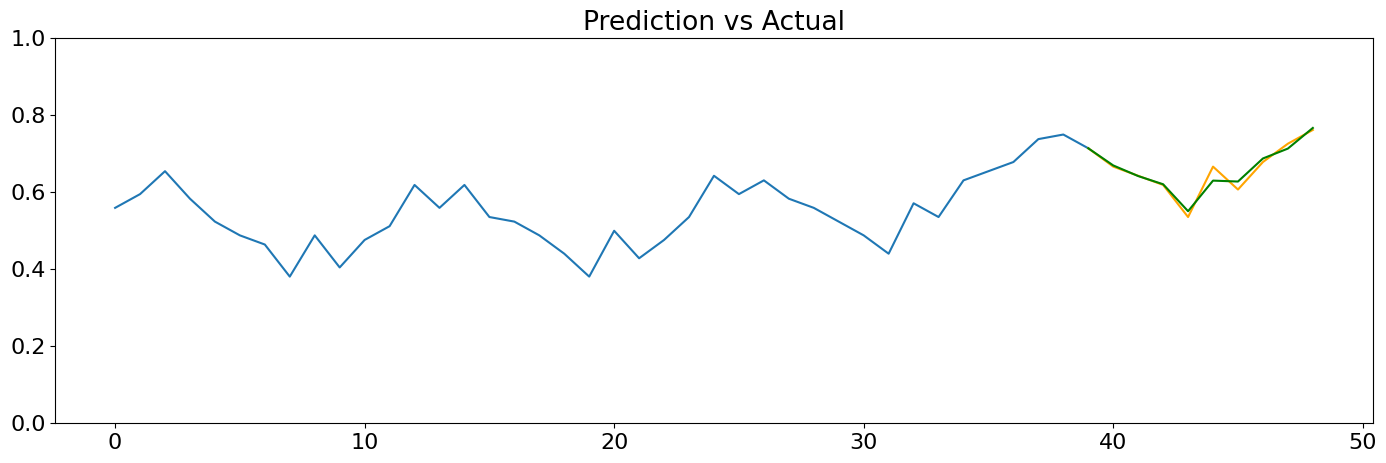

In [ ]:
inspect_univariate_prediction(X_test, y_test, predictions, telescope)